# A toy example of normalizing flow (using the VI class)

In [1]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter

from matplotlib import pyplot as plt

from tqdm import tqdm

batch_size = 128
epochs = 10000
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [2]:
from pixyz.distributions import CustomLikelihoodDistribution, Normal
from pixyz.models import VI
from pixyz.utils import get_dict_values

In [3]:
import torch
z_dim = 2

def likelihood(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - torch.log(exp1 + exp2)

    return torch.exp(-u)

p = CustomLikelihoodDistribution(var=["z"], likelihood=likelihood)

loc = torch.tensor(0.).to(device)
scale = torch.tensor(1.).to(device)
prior = Normal(loc=loc, scale=scale, var=["z_prior"], dim=z_dim, name="q_prior")

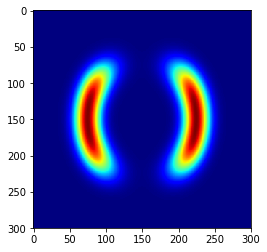

In [4]:
import numpy as np
def plot_density(p):

    X_LIMS = (-4, 4)
    Y_LIMS = (-4, 4)

    x1 = np.linspace(*X_LIMS, 300)
    x2 = np.linspace(*Y_LIMS, 300)
    x1, x2 = np.meshgrid(x1, x2)
    shape = x1.shape
    x1 = x1.ravel()
    x2 = x2.ravel()

    z = np.c_[x1, x2]
    z = torch.FloatTensor(z)
    
    p.log_likelihood({"z":z})

    density_values = torch.exp(p.log_likelihood({"z":z})).data.numpy().reshape(shape)
    plt.imshow(density_values, cmap='jet')
    plt.show()
    
plot_density(p)

In [5]:
from pixyz.distributions import PlanarFlow
q = PlanarFlow(prior, z_dim, var=["z"], num_layers=32, name="q")

p.to(device)
q.to(device)

print(q)

Distribution:
  q(z=PlanarFlow(z_prior)) (None)
Network architecture:
  PlanarFlow(
    (prior): Normal()
    (flows): ModuleList(
      (0): PlanarFlowLayer()
      (1): PlanarFlowLayer()
      (2): PlanarFlowLayer()
      (3): PlanarFlowLayer()
      (4): PlanarFlowLayer()
      (5): PlanarFlowLayer()
      (6): PlanarFlowLayer()
      (7): PlanarFlowLayer()
      (8): PlanarFlowLayer()
      (9): PlanarFlowLayer()
      (10): PlanarFlowLayer()
      (11): PlanarFlowLayer()
      (12): PlanarFlowLayer()
      (13): PlanarFlowLayer()
      (14): PlanarFlowLayer()
      (15): PlanarFlowLayer()
      (16): PlanarFlowLayer()
      (17): PlanarFlowLayer()
      (18): PlanarFlowLayer()
      (19): PlanarFlowLayer()
      (20): PlanarFlowLayer()
      (21): PlanarFlowLayer()
      (22): PlanarFlowLayer()
      (23): PlanarFlowLayer()
      (24): PlanarFlowLayer()
      (25): PlanarFlowLayer()
      (26): PlanarFlowLayer()
      (27): PlanarFlowLayer()
      (28): PlanarFlowLayer()
      (29

In [6]:
for i in range(100000):
    if i%10000 == 0:
        print(q.sample(batch_size=batch_size)["z"].shape)

torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])


In [7]:
model = VI(p, q, optimizer=optim.Adam, optimizer_params={"lr":1e-3})
print(model)

Distributions (for training): 
  p(z), q(z=PlanarFlow(z_prior)) 
Loss function: 
  mean(-(E_q(z=PlanarFlow(z_prior))[log p(z)/q(z=PlanarFlow(z_prior))])) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


In [8]:
for epoch in range(epochs):
    loss = model.train(batch_size=batch_size)
    if epoch % 500 == 0:
        loss = model.test(batch_size=batch_size)
        print('Epoch: {} Test loss: {:.4f}'.format(epoch, loss))

Epoch: 0 Test loss: 7.4908
Epoch: 500 Test loss: -1.0784
Epoch: 1000 Test loss: -1.1973
Epoch: 1500 Test loss: -1.1685
Epoch: 2000 Test loss: -1.1874
Epoch: 2500 Test loss: -1.1823
Epoch: 3000 Test loss: -1.1890
Epoch: 3500 Test loss: -1.1816
Epoch: 4000 Test loss: -1.1658
Epoch: 4500 Test loss: -1.1790
Epoch: 5000 Test loss: -1.1942
Epoch: 5500 Test loss: -1.2570
Epoch: 6000 Test loss: -1.2487
Epoch: 6500 Test loss: -1.6201
Epoch: 7000 Test loss: -1.6963
Epoch: 7500 Test loss: -1.7701
Epoch: 8000 Test loss: -1.7980
Epoch: 8500 Test loss: -1.8739
Epoch: 9000 Test loss: -1.8197
Epoch: 9500 Test loss: -1.7986


In [9]:
def plot_samples(points):
    X_LIMS = (-4, 4)
    Y_LIMS = (-4, 4)

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s=25)
    ax.set_xlim(*X_LIMS)
    ax.set_ylim(*Y_LIMS)

    plt.show()

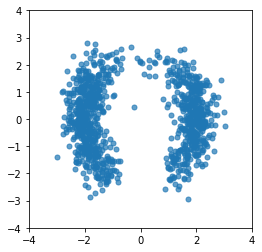

In [10]:
samples = q.sample(batch_size=1000)
plot_samples(samples["z"].cpu().data.numpy())